In [ ]:
!mamba install famsa t-coffee mmseqs2 -y

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
from learnMSA import msa_hmm
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../MSA-HMM-Analysis')
from src import Util

## MSA HMM Interactive

1. Fit n models, keep the best and align
2. Compare to a reference
3. Visualize the HMM

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

## Training

In [7]:
out_filename = "test/data/interactive.alignment.fasta"
config = msa_hmm.config.make_default(num_models)
alignment_model = msa_hmm.align.run_learnMSA(train_filename,
                                              out_filename,
                                              config, 
                                              sequence_weights=msa_hmm.align.compute_sequence_weights(train_filename, "tmp"),
                                              verbose=True,
                                              align_insertions=True)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

>l=-55.48_t=0.01
............$C.D.....P........N............P........CYN.HG..T..C...S......................L.......RA...T........G..........YTCSCL....PR......YT....GEH$.......................
>l=-57.11_t=0.01
............$C.D.....S........Q............P........CRN.-G..T..Cs..L......................N.......TN...T........D..........YTCACF....PG......YT....GRY$.......................
>l=-50.46_t=0.01
............$C.D.....S........D............P........CLN.GG..T..C...T......................L.......RSl..D........S..........YSCACA....PG......YT....GQH$.......................
>l=-63.44_t=0.01
............$C.D.....H........V............T........CLN.GG..T..C...Q......................Lk......TL...E........D..........YTCACA....NG......YT....GER$.......................
>l=-64.05_t=0.01
............$C.D.....H........V............T........CLN.GG..T..C...Q......................Lk......TL...E........E..........YTCACA....NG......YT....GDR$.......................
>l=-64.17_t=0.01
............$C.D.....H.

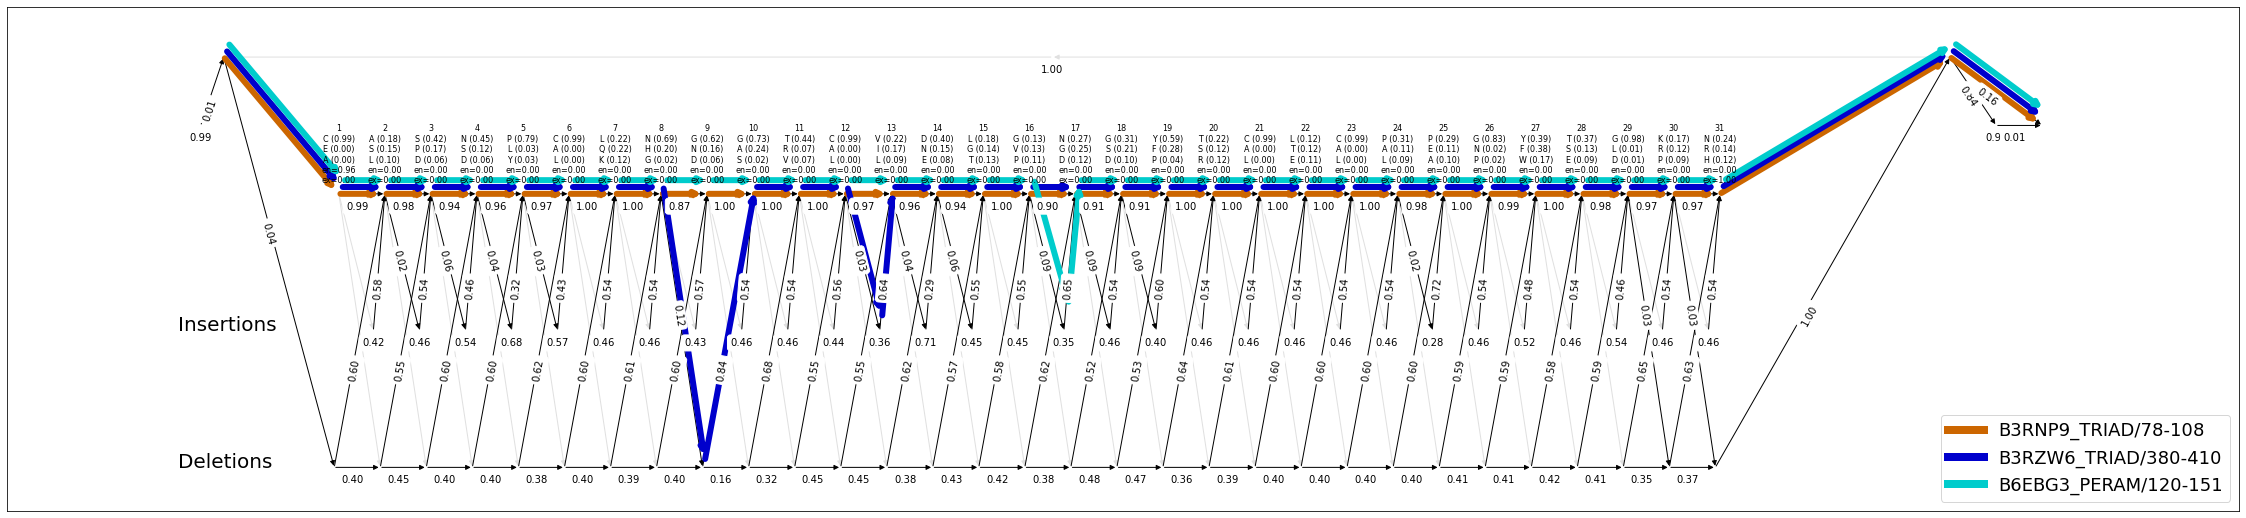

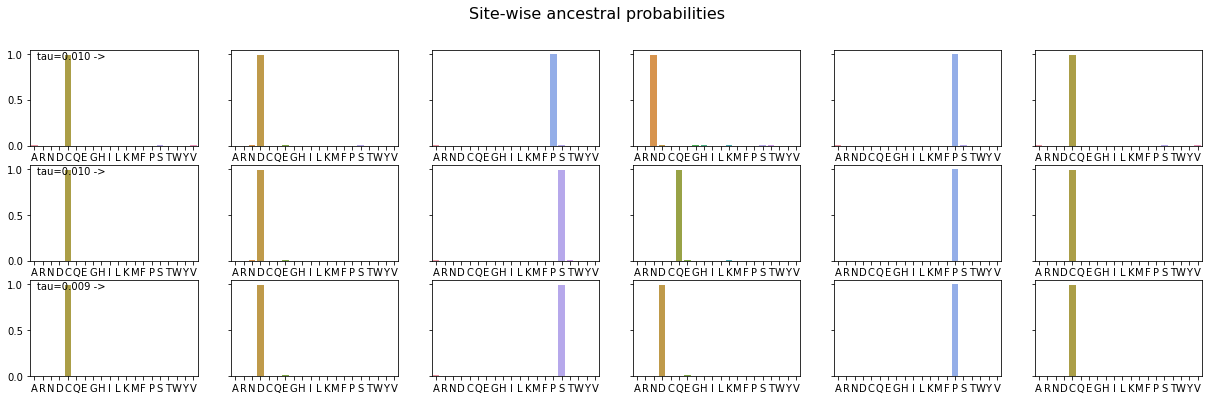

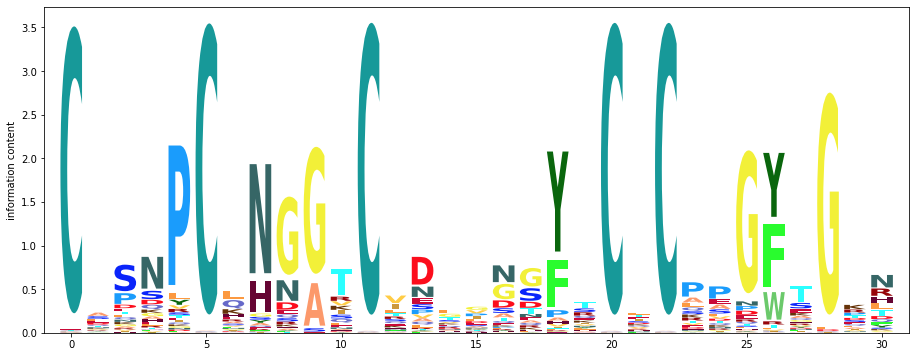

In [8]:
msa_hmm.vis.print_and_plot(alignment_model, alignment_model.best_model)

In [ ]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

In [ ]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp